## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [80]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

#Same as get_city_trajectories, but combines the data from all cities
def get_all_trajectories(split="train", normalized=False):
    total_inputs, total_outputs = get_city_trajectories(city=cities[0], split=split,normalized=normalized)
    
    for i in range(1,len(cities)):
        city = cities[i]
        inputs,outputs = get_city_trajectories(city=city, split=split,normalized=normalized)
        total_inputs = np.concatenate((total_inputs,inputs))
        
        if total_outputs is not None:
            total_outputs = np.concatenate((total_outputs,outputs))

    return total_inputs, total_outputs

def get_all_trajectories_with_city(split="train", normalized=False):
    total_inputs, total_outputs = get_city_trajectories(city=cities[0], split=split,normalized=normalized)
    total_inputs=np.concatenate((total_inputs,indexToSizedOneHot(0,len(total_inputs))),axis=1)
    
    for i in range(1,len(cities)):
        city = cities[i]
        inputs,outputs = get_city_trajectories(city=city, split=split,normalized=normalized)
        inputs=np.concatenate((inputs,indexToSizedOneHot(i,len(inputs))),axis=1)
        total_inputs = np.concatenate((total_inputs,inputs))
        
        if total_outputs is not None:
            total_outputs = np.concatenate((total_outputs,outputs))

    return total_inputs, total_outputs

def indexToOneHot(index):
    temp = torch.zeros(6)
    temp[index] = 1
    return temp

def indexToSizedOneHot(index,count):
    temp = np.zeros((count,len(cities),2))
    temp[:,index,:] = 1
    return temp

def get_category_trajectories(split="train", normalized=False):
    total_inputs, temp = get_city_trajectories(city=cities[0], split=split,normalized=normalized)
    total_outputs = indexToOneHot(0).repeat(len(total_inputs),1)
    
    for i in range(1,len(cities)):
        city = cities[i]
        inputs,temp = get_city_trajectories(city=city, split=split,normalized=normalized)
        total_inputs = np.concatenate((total_inputs,inputs))
        total_outputs = np.concatenate((total_outputs,indexToOneHot(i).repeat(len(total_inputs),1)))

    return total_inputs, total_outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ArgoverseDatasetAllCities(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDatasetAllCities, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_all_trajectories(split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ArgoverseDatasetAllCitiesWithCityIndex(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDatasetAllCitiesWithCityIndex, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_all_trajectories_with_city(split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ArgoverseCategoryDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseCategoryDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_category_trajectories(split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
for city in cities:
    split = 'train'
    train_dataset  = ArgoverseDataset(city = city, split = split)
    print(len(train_dataset))
    
    
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)
print(len(train_dataset))

43041
55029
43544
24465
25744
11993
11993


## Create a DataLoader class for training

In [3]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

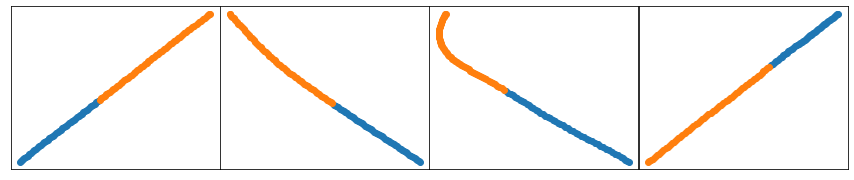

In [4]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

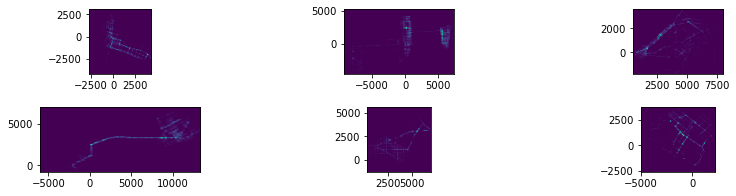

In [5]:
import numpy.random

def makeHeatmap(dataset, axis):
    train_loader = DataLoader(dataset,batch_size=len(dataset))
    #Heatmap of all input positions for all time steps specifically for a given dataset
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch

        x = []
        y = []
        for i in range(len(inp[0])):
            x = numpy.append(x,torch.squeeze(inp[:,i,0]).numpy())
            y = numpy.append(y,torch.squeeze(inp[:,i,1]).numpy())

        heatmap, xedges, yedges = np.histogram2d(x, y, bins=80)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        axis.imshow(heatmap.T, extent=extent, origin='lower')

split = 'train'
fig, axs = plt.subplots(2, 3, figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel() 
for i_city, city in enumerate(cities):
    train_dataset  = ArgoverseDataset(city = city, split = split)
    makeHeatmap(train_dataset, axs[i_city])
plt.show()

In [81]:
import torch.nn as nn

mlp = nn.Sequential(nn.Flatten(),
                    nn.Linear(112, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                   nn.Unflatten(1,(60,2)))

#From d2l's tutorial. Might be useful, but I'm ignoring it for now
#def init_weights(m):
#    if type(m) == nn.Linear:
#        nn.init.normal_(m.weight, std=0.01)


In [111]:
full_dataset  = ArgoverseDatasetAllCitiesWithCityIndex(split = "train")
#full_dataset  = ArgoverseDatasetAllCities(split = "train")
#Split into training and validation:
#train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*5/6), len(full_dataset)-int(len(full_dataset)*5/6)])
train_set = full_dataset
#Batch size for both currently set to be the entire dataset. Might lead to problems with overfitting, but it doesn't learn anything when I don't do this
train_loader = DataLoader(train_set,batch_size=len(train_set),shuffle=True)
#validation_loader = DataLoader(validation_set,batch_size=len(validation_set))

In [114]:
opt = torch.optim.Adam(mlp.parameters(),lr=0.003)

loss = nn.MSELoss()

num_epochs = 300

plot_every = 2
all_losses = []
all_losses2 = []#validation
total_loss = 0

for epoch in range(num_epochs):
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.float()
        categories = torch.zeros(len(inp),1,2)
        #print(inp.shape)
        #print(torch.zeros(len(inp),1,2).shape)
        #inp = torch.cat((inp,torch.zeros(len(inp),1,2)),dim=1)
        #print(inp.shape)
        #inp = torch.cat((inp,torch.zeros(1,2)))
        #print(inp.shape)
        out = out.float()
        l = ((mlp(inp) - out) ** 2).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        total_loss += l.item()
        #if i_batch % plot_every == 0 and i_batch != 0:
            #all_losses.append(total_loss / len(train_set))
    #for i_batch, sample_batch in enumerate(validation_loader):
    #    inp, out = sample_batch
    #    inp = inp.float()
    #    out = out.float()
    #    l = ((mlp(inp) - out) ** 2).sum()
    #    print(f'(validation) epoch {epoch + 1}, loss {(l / len(validation_set)):f}')
    #    all_losses2.append(l.item() / len(validation_set))
    print(f'(train) epoch {epoch + 1}, loss {(total_loss / len(train_set)):f}')
    all_losses.append(total_loss / len(train_set))
    total_loss = 0
    

(train) epoch 1, loss 106541.156965
(train) epoch 2, loss 27038077.191506
(train) epoch 3, loss 4710633.763159
(train) epoch 4, loss 12819846.878047
(train) epoch 5, loss 12351081.969149
(train) epoch 6, loss 8532689.064490
(train) epoch 7, loss 3147526.722299
(train) epoch 8, loss 4260465.404875
(train) epoch 9, loss 5975147.757742
(train) epoch 10, loss 4698590.298073
(train) epoch 11, loss 4816204.999961
(train) epoch 12, loss 3935451.333831
(train) epoch 13, loss 2596885.061192
(train) epoch 14, loss 2634056.458139
(train) epoch 15, loss 1745157.416022
(train) epoch 16, loss 1517935.445461
(train) epoch 17, loss 2716842.057071
(train) epoch 18, loss 2387527.161911
(train) epoch 19, loss 1685112.117125
(train) epoch 20, loss 1235940.628488
(train) epoch 21, loss 558632.293598
(train) epoch 22, loss 1002302.791694
(train) epoch 23, loss 1560069.245202
(train) epoch 24, loss 1285809.432508
(train) epoch 25, loss 1138021.437375
(train) epoch 26, loss 841720.443694
(train) epoch 27, los

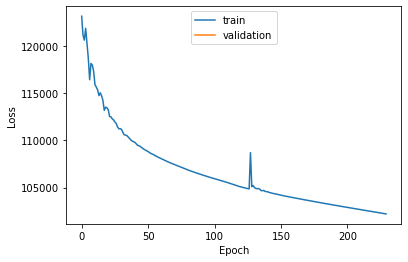

In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[70:],label="train")

plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(all_losses2[70:],label="validation")
leg = plt.legend(loc='upper center')
plt.show()

In [65]:
#Not currently working well
def show_sample_batch2(sample_batch,prediction):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    
    
    fig, axs = plt.subplots(1,batch_sz*2, figsize=(17, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.5)
    axs = axs.ravel()   
    for i in range(batch_sz):
        #axs[i].xaxis.set_ticks([])
        #axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        #axs[i].scatter(inp[i,:,0], inp[i,:,1])
        #if i == 0:
            #print(inp[i,:,0])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        #axs[i].set_title("hello")
        
                
    for i in range(batch_sz):
        #axs[i+batch_sz].xaxis.set_ticks([])
        #axs[i+batch_sz].yaxis.set_ticks([])
        
        
        
        # first two feature dimensions are (x,y) positions
        #if i == 0:
            #print(inp[i,:,0])
        #axs[i+batch_sz].scatter(inp[i,:,0], inp[i,:,1])
        #print(prediction[i,:,0])
        #print(inp[i,:,0])
        axs[i+batch_sz].scatter(prediction[i,:,0], prediction[i,:,1])

    plt.tick_params(axis='both', which='both', labelsize=7)
    plt.show()

In [45]:
#Validation

validation_loader2 = DataLoader(validation_set,batch_size=1)
training_loader2 = DataLoader(train_set,batch_size=1)
print("Left: ground truth, right: our prediction")
for i_batch, sample_batch in enumerate(training_loader2):
    inp, out = sample_batch
    inp = inp.float()
    out = out.float()
    #print(inp.shape)
    #print(out)
    #print(mlp(inp))
    #l = loss(mlp(inp) ,out)
    #print(l)
    show_sample_batch2(sample_batch,mlp(inp).detach())
    if i_batch > 5:
        break

Left: ground truth, right: our prediction


NameError: name 'show_sample_batch2' is not defined

In [116]:
test_lengths = []
for city in cities:
    split = 'test'
    test_dataset  = ArgoverseDataset(city = city, split = split)
    test_lengths.append(len(test_dataset))
    
for le in test_lengths:
    print(le)

6325
7971
6361
3671
3829
1686


In [117]:
#Test

split = 'test'
counter = 0
currCity = 0
test_input, test_output = get_all_trajectories_with_city(split="test", normalized=False)
#We can't use a dataset or a dataloader because they don't work for the test set (something to do with the fact that the test set doesn't have outputs)

with open('predictions.txt', 'w') as f:
    print("hello",file=f, flush=True)
    for i_batch, curr_input in enumerate(test_input):
        #curr_input is a numpy array, so first we need to turn it into a tensor, then add an extra dimension around it, then make it a float tensor instead of a double tensor
        predict = mlp(torch.from_numpy(curr_input).unsqueeze(0).float())

        print("" + str(counter) + "_" + str(cities[currCity]),end='',file=f)
        for coor in predict[0]:
            print("," + str(coor[0].item()) + "," + str(coor[1].item()),end='',file=f)
        print(file=f, flush=True)
        counter = counter+1
        if counter >= test_lengths[currCity]:
            counter = 0
            currCity = currCity+1

    f.close()

In [14]:
import torch.nn as nn

categorize = nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 6),
                    nn.LogSoftmax(dim=1))

full_dataset  = ArgoverseCategoryDataset(split = "train")
#Split into training and validation:
train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*3/6), len(full_dataset)-int(len(full_dataset)*3/6)])

batch_sz = 500
#Batch size for both currently set to be the entire dataset. Might lead to problems with overfitting, but it doesn't learn anything when I don't do this
train_loader = DataLoader(train_set,batch_size=batch_sz,shuffle=True)
validation_loader = DataLoader(validation_set,batch_size=len(validation_set))

In [15]:
opt = torch.optim.Adam(mlp.parameters(),lr=0.004)

criterion = nn.CrossEntropyLoss()

num_epochs = 10

plot_every = 2
all_losses = []
all_losses2 = []#validation
total_loss = 0

for epoch in range(num_epochs):
    for i_batch, sample_batch in enumerate(train_loader):
        #print(i_batch)
        inp, out = sample_batch
        inp = inp.float()
        out = out.float()
        #l = ((mlp(inp) - out) ** 2).sum()
        opt.zero_grad()
        l = 0
        for scene in range(len(inp)):
        #    print(categorize(inp[scene].unsqueeze(dim=0)),out[scene].unsqueeze(dim=0))
            #print(inp[scene].shape)
            #print(categorize(inp[scene]))
            l += loss(categorize(inp[scene].unsqueeze(dim=0)),torch.argmax(out[scene].unsqueeze(dim=0),1))
        #print(categorize(inp).squeeze())
        #print(out)
        #print(torch.argmax(out,1))
        #print(inp.shape)
        #l = criterion(categorize(inp),torch.argmax(out,1))
        l.backward()
        opt.step()
        total_loss += l.item()
        #if i_batch % plot_every == 0 and i_batch != 0:
            #all_losses.append(total_loss / len(train_set))
    print(f'(train) epoch {epoch + 1}, loss {(total_loss / len(train_set)):f}')
    all_losses.append(total_loss / len(train_set))
    total_loss = 0

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Long but expected Float


loss = nn.CrossEntropyLoss()
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#output = loss(input, target)

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)

In [6]:
import torch.nn as nn

mlps = [nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2))),
        nn.Sequential(nn.Flatten(),
                    nn.Linear(100, 64),
                    nn.ELU(),
                    nn.Linear(64, 32),
                    nn.ELU(),
                    nn.Linear(32, 64),
                    nn.ELU(),
                    nn.Linear(64, 120),
                    nn.ELU(),
                   nn.Unflatten(1,(60,2)))]


In [10]:
full_datasets   = []
train_sets      = []
validation_sets = []
for i_city, city in enumerate(cities):
    full_datasets.append(ArgoverseDataset(city=city, split = "train"))
    temp1, temp2 = torch.utils.data.random_split(full_datasets[i_city], [int(len(full_datasets[i_city])*5/6), len(full_datasets[i_city])-int(len(full_datasets[i_city])*5/6)])
    train_sets.append(temp1)
    validation_sets.append(temp2)

#Batch size for both currently set to be the entire dataset. Might lead to problems with overfitting, but it doesn't learn anything when I don't do this
train_loaders      = []
validation_loaders = []

for i in range(len(cities)):
    train_loaders.append(DataLoader(train_sets[i],batch_size=len(train_sets[i]),shuffle=True))
    validation_loaders.append(DataLoader(validation_sets[i],batch_size=len(validation_sets[i])))

In [19]:
def train_loop(mlp, train_loader, validation_loader, batch_sz, batch_sz_validation, num_epochs=70, loss=nn.MSELoss(), lr=0.004):
    print("Starting training on a new model")
    opt = torch.optim.Adam(mlp.parameters(),lr=lr)
    plot_every = 2
    all_losses = []
    all_losses2 = []#validation
    total_loss = 0

    for epoch in range(num_epochs):
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            inp = inp.float()
            out = out.float()
            l = ((mlp(inp) - out) ** 2).sum()
            opt.zero_grad()
            l.backward()
            opt.step()
            total_loss += l.item()
            #if i_batch % plot_every == 0 and i_batch != 0:
                #all_losses.append(total_loss / len(train_set))
        for i_batch, sample_batch in enumerate(validation_loader):
            inp, out = sample_batch
            inp = inp.float()
            out = out.float()
            l = ((mlp(inp) - out) ** 2).sum()
            print(f'(validation) epoch {epoch + 1}, loss {(l / batch_sz_validation):f}')
            all_losses2.append(l.item() / batch_sz_validation)
        print(f'(train) epoch {epoch + 1}, loss {(total_loss / batch_sz):f}')
        all_losses.append(total_loss / batch_sz)
        total_loss = 0

In [21]:
loss=nn.MSELoss()
num_epochs = 40
lr=0.004

for i in range(len(cities)):
    train_loop(mlps[i],train_loaders[i],validation_loaders[i],len(train_sets[i]),len(validation_sets[i]),num_epochs,loss,lr)

Starting training on a new model
(validation) epoch 1, loss 161131504.000000
(train) epoch 1, loss 158608163.566064
(validation) epoch 2, loss 155394960.000000
(train) epoch 2, loss 166601965.906488
(validation) epoch 3, loss 157678304.000000
(train) epoch 3, loss 160827796.095575
(validation) epoch 4, loss 154329168.000000
(train) epoch 4, loss 163153435.165249
(validation) epoch 5, loss 154763920.000000
(train) epoch 5, loss 159663726.759417
(validation) epoch 6, loss 155592464.000000
(train) epoch 6, loss 160119516.876460
(validation) epoch 7, loss 154829344.000000
(train) epoch 7, loss 161008673.774556
(validation) epoch 8, loss 154097568.000000
(train) epoch 8, loss 160254246.920679
(validation) epoch 9, loss 154368992.000000
(train) epoch 9, loss 159506953.435749
(validation) epoch 10, loss 154609584.000000
(train) epoch 10, loss 159777524.458695
(validation) epoch 11, loss 153600368.000000
(train) epoch 11, loss 160026607.669445
(validation) epoch 12, loss 152264048.000000
(trai

In [24]:
#Test

split = 'test'
counter = 0
currCity = 0
test_input, test_output = get_all_trajectories(split="test", normalized=False)
#We can't use a dataset or a dataloader because they don't work for the test set (something to do with the fact that the test set doesn't have outputs)

with open('predictions.txt', 'w') as f:
    print("hello",file=f, flush=True)
    for i_batch, curr_input in enumerate(test_input):
        #curr_input is a numpy array, so first we need to turn it into a tensor, then add an extra dimension around it, then make it a float tensor instead of a double tensor
        predict = mlps[currCity](torch.from_numpy(curr_input).unsqueeze(0).float())

        print("" + str(counter) + "_" + str(cities[currCity]),end='',file=f)
        for coor in predict[0]:
            print("," + str(coor[0].item()) + "," + str(coor[1].item()),end='',file=f)
        print(file=f, flush=True)
        counter = counter+1
        if counter >= test_lengths[currCity]:
            counter = 0
            currCity = currCity+1

    f.close()

In [32]:
temp1 = np.zeros((5,50,2))
temp2 = np.zeros((5,1,2))
print(np.concatenate((temp1,temp2),axis=1).shape)


(5, 51, 2)
